In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz

--2021-12-08 08:13:11--  https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 300965906 (287M) [application/x-gzip]
Saving to: ‘spark-3.2.0-bin-hadoop3.2.tgz’

spark-3.2.0-bin-had 100%[===================>] 287.02M   158MB/s    in 1.8s    

2021-12-08 08:13:13 (158 MB/s) - ‘spark-3.2.0-bin-hadoop3.2.tgz’ saved [300965906/300965906]



In [5]:
!tar xvzf spark-3.2.0-bin-hadoop3.2.tgz

spark-3.2.0-bin-hadoop3.2/
spark-3.2.0-bin-hadoop3.2/NOTICE
spark-3.2.0-bin-hadoop3.2/kubernetes/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/python_executable_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/autoscale.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/worker_memory_check.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/py_container_checks.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/pyfiles.py
spark-3.2.0-bin-hadoop3.2/kubernetes/tests/decommissioning_cleanup.py
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/decom.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/entrypoint.sh
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/
spark-3.2.0-bin-hadoop3.2/kubernetes/dockerfiles/spark/bindings/R/
spark-3.2.0-bin-hadoop3.2/kubernetes/docker

In [6]:
!ls /content/spark-3.2.0-bin-hadoop3.2

bin   data	jars	    LICENSE   NOTICE  R		 RELEASE  yarn
conf  examples	kubernetes  licenses  python  README.md  sbin


In [7]:
# Set the ‘environment’ path
import os
#os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"

In [8]:
!pip install -q findspark

import findspark
findspark.init()

In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import pandas as pd
import matplotlib.pyplot as plt


spark = SparkSession.builder\
    .master("local[*]")\
    .appName("final-project")\
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

In [8]:
sc

<SparkContext master=local[*] appName=final-project>

In [25]:
#The wildfire location database 
locatData = spark.read.option("header",True) \
.option("inferSchema", True) \
.csv("WFIGS_-_Wildland_Fire_Locations_Full_History.csv")

Fire Frequency By Year

In [26]:
#locTime will be used to focus on the frequency of wildfires per state
#POOState - Location of wildfire at time of discovery
#FireDiscoveryDateTime - Date when the fire was discovered.
locTime = locatData.select(substring(locatData["POOState"],0,6).alias("State Occurred"),
                           substring(locatData['FireDiscoveryDateTime'],0,4).alias("Year"))

In [27]:
#Unusable rows are filtered out.
locTime = locTime.filter((locTime["year"].isNotNull())& (locTime["State Occurred"].isNotNull()))\

A significant difference between the wildfire frequency was found between 2013 and 2014; it is assumed the years before 2014 had incomplete data.

In [28]:

locTime.groupBy("Year").count().orderBy("year").show()


+----+-----+
|Year|count|
+----+-----+
|2003|    1|
|2004|    1|
|2008|    3|
|2009|   18|
|2010|    7|
|2011|   20|
|2012|    4|
|2013|   16|
|2014|12618|
|2015|19709|
|2016|20181|
|2017|25578|
|2018|23868|
|2019|29117|
|2020|35349|
|2021| 3656|
+----+-----+



Number of Fires across the  US per state

In [29]:
#To gain insights into the US results, areas outside the US are filtered out.
locTime = locTime.filter(locTime["Year"] > 2013)
locTime = locTime.filter(locTime["State Occurred"].contains("US"))
locTime = locTime.withColumn("State Occurred",substring(locTime["State Occurred"],4,6))

In [30]:
locTime.show()

+--------------+----+
|State Occurred|Year|
+--------------+----+
|            MT|2020|
|            CA|2020|
|            MT|2017|
|            CA|2019|
|            CA|2016|
|            MS|2020|
|            UT|2019|
|            MT|2020|
|            SD|2020|
|            CA|2015|
|            FL|2019|
|            AZ|2019|
|            CA|2017|
|            ID|2020|
|            CA|2016|
|            MT|2019|
|            UT|2016|
|            MT|2018|
|            TX|2021|
|            MS|2019|
+--------------+----+
only showing top 20 rows



In [31]:
totalFiresPerState = locTime.groupBy("State Occurred").count()

In [32]:
import plotly.express as px
import pandas as pd

fig = px.choropleth(totalFiresPerState.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "count", 
                    scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

Findings:
From the figure above, it can be seen that fires in the last decade have most occurred in the western portion of the United States, and have been mostly prevalent on the west coast as well as Montana and Arizona.

Number of Fires Per Year Per State

In [33]:
firePerState = locTime.filter(locTime["year"].isNotNull())\
.groupBy("year",'State Occurred').count().orderBy("Year")

In [34]:
firePerState.show()

+----+--------------+-----+
|year|State Occurred|count|
+----+--------------+-----+
|2014|            WI|   11|
|2014|            IL|    3|
|2014|            VA|   14|
|2014|            HI|    2|
|2014|            GA|   25|
|2014|            NM|  516|
|2014|            MI|   65|
|2014|            AK|  374|
|2014|            WV|    1|
|2014|            CO|  616|
|2014|            MO|    7|
|2014|            FL|  183|
|2014|            NC|   48|
|2014|            SC|   21|
|2014|            NV|  526|
|2014|            MD|    3|
|2014|            AZ|  945|
|2014|            WA|  822|
|2014|            AL|   32|
|2014|            ID|  985|
+----+--------------+-----+
only showing top 20 rows



In [52]:
import plotly.express as px
import pandas as pd

fig = px.choropleth(firePerState.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "count",range_color = [0,5000],
                    animation_frame="year", animation_group="State Occurred",scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

**Findings** : From the above, figure, we see a general rise in wildfire occurences over the years. The west coast has consistently had the highest number of fires over the years. Originally the majority of fires had been originating in the west coast, but states east of it have steadily seen increasing occurences.It should be noted that data for 2021 is incomplete.

Acres Burned Across the US Per Year

In [41]:
#The Data in this csv primarily tracks the area of each recorded fire.
perimData = spark.read.option("header",True) \
.option("inferSchema", True) \
.csv("WFIGS_-_Wildland_Fire_Perimeters_Full_History.csv")

In [42]:
#perimTime will be used to focus on the area damaged by wildfires, per state and overall
#The dataset only shows signficant data from 2019 onwards, so analysis will be month by month.
perimTime = perimData.select(substring(perimData["irwin_POOState"],4,6).alias("State Occurred"),
                             perimData["poly_Acres_AutoCalc"].alias("area(acres)"),
                             substring(perimData['irwin_ContainmentDateTime'],0,4).alias("year"),
                             substring(perimData['irwin_ContainmentDateTime'],6,2).alias("month"),
                             substring(perimData['irwin_ContainmentDateTime'],0,7).alias("year/month"))
perimTime = perimTime.filter(perimTime["year"].isNotNull())


In [43]:
#Used for analysis of total area burned by wildfires across the  US
overallAffected = perimTime.groupBy("year/month").agg(sum('area(acres)').alias("area (acres)")).orderBy("year/month")

In [44]:

overallAffected.show()

+----------+------------------+
|year/month|      area (acres)|
+----------+------------------+
|   2018/06|  1.70988672404488|
|   2018/08|0.0232932508259032|
|   2019/10|  42.2824011427289|
|   2019/11|  11.1249207256351|
|   2019/12| 0.384916101758091|
|   2020/01|1333.3562204796733|
|   2020/02| 5574.576917562359|
|   2020/03|23299.046849063558|
|   2020/04| 18463.69067194689|
|   2020/05| 82474.71160321498|
|   2020/06| 198061.4936478917|
|   2020/07|  833440.703834384|
|   2020/08| 530746.8560419319|
|   2020/09|1476742.5169804976|
|   2020/10| 853609.8450898579|
|   2020/11|1484642.5787928682|
|   2020/12|1618261.3825070355|
|   2021/01| 199445.1516883008|
|   2021/02| 9296.490508084951|
|   2021/03| 109923.9058066683|
+----------+------------------+
only showing top 20 rows



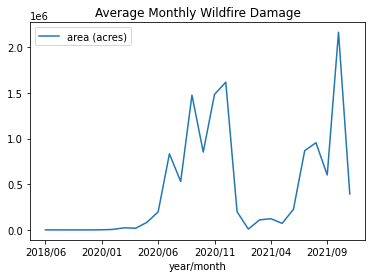

In [45]:
#Will work on the x-axis
plt1 = overallAffected.toPandas()
plt1.plot(
    x="year/month",
    y = "area (acres)",
    title = "Average Monthly Wildfire Damage")


Total Area Burned Per State

In [46]:
areaPerState= perimTime.groupBy("State Occurred").agg(sum('area(acres)').alias("total area burned (acres)"))

In [47]:
import plotly.express as px
import pandas as pd
fig = px.choropleth(areaPerState.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "total area burned (acres)", 
                    scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

**Findings**: The above map shows that the most significant damage was found on the west coast; this is similar and supports the findings found in the occurences map. Some States that had a high number of fire occurences such as Texas have not seen proportional quantities of acres burned.

Area Burned Per State Per Month

In [48]:
areaPerStateMonthly = perimTime.groupBy("year/month","State Occurred").agg(sum('area(acres)').alias("total area burned (acres)")).orderBy("year/month")

In [51]:
import plotly.express as px
import pandas as pd
fig = px.choropleth(areaPerStateMonthly.toPandas(), locations='State Occurred',locationmode = "USA-states",color = "total area burned (acres)", 
                    range_color = [0,500000],animation_frame="year/month", animation_group="State Occurred",scope='usa')
fig.update_layout(
    width=800,
    height=600)

fig.show()

**Findings**: In the above figure, we can see that damage is found across the US in April for both 2020 and 2021, but area burned has been relatively small. The most significant damage was found between September and October, and tends to be localized in west coast states such as Oregon and California